### Set Up

1. We set ```%load_ext autoreload``` and ```%autoreload 2``` to reload modules instantly when changes had been made in these modules.
2. We use the Intel(R) Extension for Scikit-learn.
3. We identify the ```root``` directory with ```pathlib.Path().resolve()```. In case the Jupyter Notebook is connected with a remote Jupyter server, we look for the directory ```t.ex-Graph``` in ```root```. **NOTE:** Therefore, you have to clone the ```t.ex-Graph``` repository to the home directory of the user, who runs the remote Jupyter notebook. Alternatively, you can simply configure ```root``` yourself.
4. We import the modules contained in ```lib/``` to hide most of the boilerplate code.

In [372]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [373]:
from sklearnex import patch_sklearn 

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [374]:
from os.path import expanduser, join
import pathlib

root = pathlib.Path().resolve()

In [375]:
from os import listdir

dir = listdir(root)
if 't.ex-Graph' in dir:
  root = join(root, 't.ex-Graph')

In [376]:
import sys
sys.path.insert(1, join(root, 'lib'))

import config
import data
import model
import export

### Data Sets

We use the two variants of t.ex-Graph: the one, in which nodes represent fully qualified domain names (FQDN), and the one, in which nodes represent a second-level domain (SLD). Therefore, we read in the two files ```graph-data-fqdn.csv``` and ```graph-data-sld.csv```, respectively. We derive a label ```binary_tracker``` from the column ```tracking```, which represents the ratio between incoming tracking requests and the total number of incoming requests. We label a node as ```tracker``` (or ```1```), if this ratio is greater than 0, and as ```non-tracker``` (or ```0```), if the ratio is 0.

In [377]:
datasets = [

  {
    'label': 't.ex-Graph (FQDN)',
    'data': data.read(join(root, 'data', 'graph-data-fqdn.csv')),
    'smote': True
  },

  {
    'label': 't.ex-Graph (SLD)',
    'data': data.read(join(root, 'data', 'graph-data-sld.csv')),
    'smote': True
  },

]

In [378]:
for dataset in datasets:
  data.binary_classification_labels(
    config.binary_tracker, 
    dataset.get('data'),
    lambda x : x > 0.5
  )

### Inbalanced Tracker Distribution

We investigate the distribution of ```tracker``` and ```non-tracker```. As we can see in the figure below, the majority of nodes is labeled as ```non-tracker```, i.e. that these nodes do not retrieve a single tracking request. The distribution varies between the two variants of t.ex-Graph. 

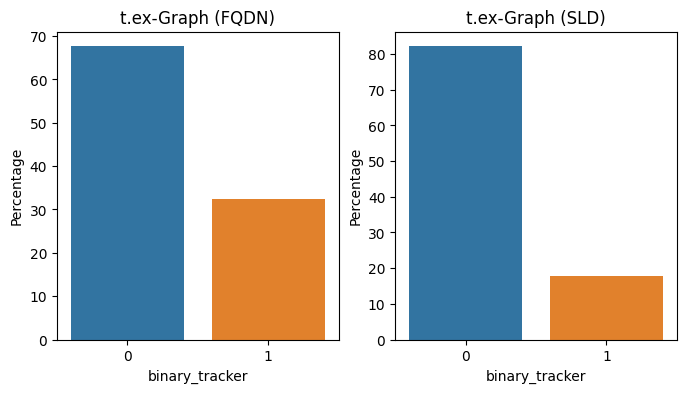

In [379]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from export import mkdir_p
from os.path import join

fig, axes = plt.subplots(ncols=len(datasets), figsize=(8, 4))

for index, dataset in enumerate(datasets):
  x = dataset['data'][config.binary_tracker]
  percentage = lambda i: len(i) / float(len(x)) * 100
  sns.barplot(
    x=x, y=x, ax=axes[index], estimator=percentage
  ).set(
    title=dataset['label'], 
    xlabel=config.binary_tracker,
    ylabel='Percentage'
  )

dir = join(root, config.results_dir)
mkdir_p(dir)
plt.savefig(join(dir, 'inbalanced-tracker-distribution.pdf'), dpi=300)

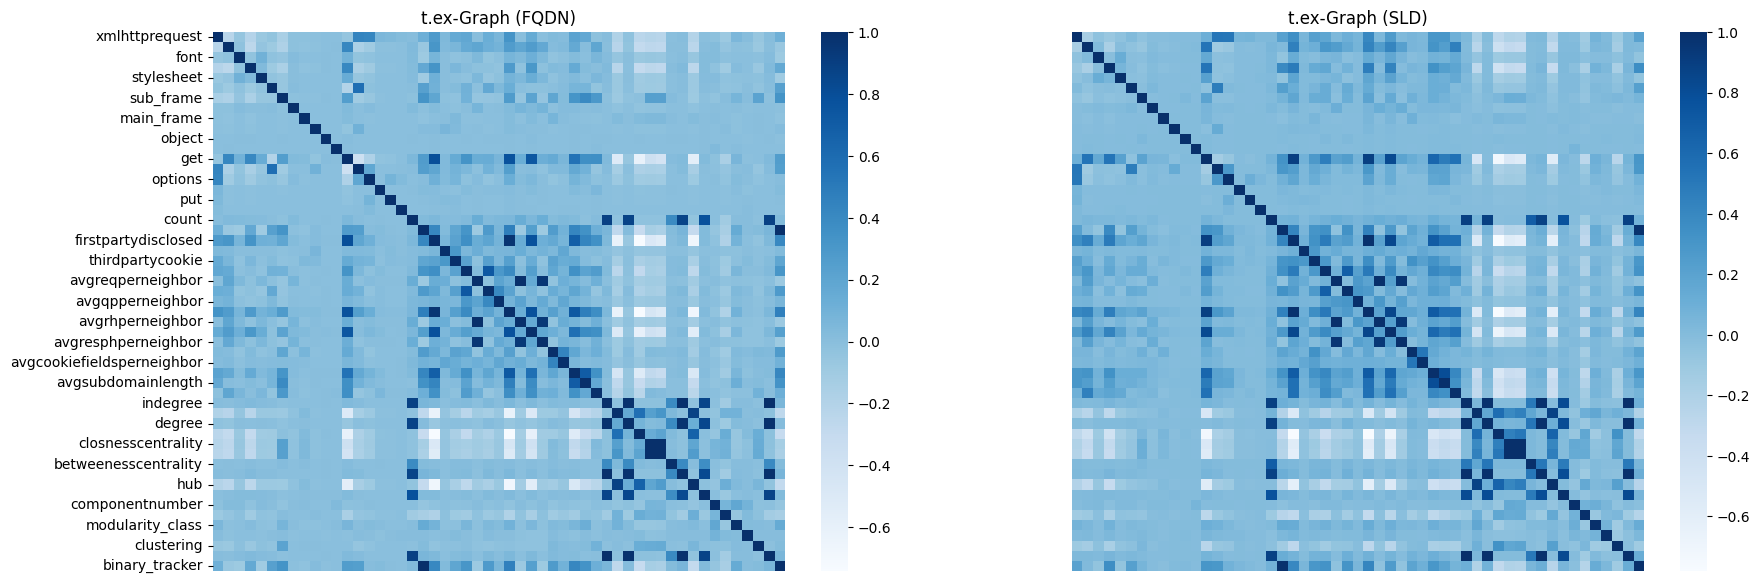

In [389]:
%matplotlib inline

fig, axes = plt.subplots(ncols=len(datasets), figsize=(18, 7))

for index, dataset in enumerate(datasets):
  corr = dataset['data'].corr(numeric_only=True)
  
  ax = sns.heatmap(corr, cmap='Blues', ax=axes[index])
  ax.set(
    title=dataset['label'],
    xticks=[]
  )

  if index == 1:
    ax.set(yticks=[])

dir = join(root, config.results_dir)
mkdir_p(dir)
plt.subplots_adjust(right=1)
plt.savefig(join(dir, 'dataset-correlations.pdf'), dpi=300)

In [381]:
features = data.feature_vector(datasets[0].get('data'))

In [382]:
targets = [ 
  config.binary_tracker
]

In [383]:
models = dict()
for target in targets:
  models[target] = list()

In [384]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

models[config.binary_tracker] = [
    LogisticRegression(max_iter=10000, solver='liblinear', n_jobs=-1),
    KNeighborsClassifier(weights='distance', n_jobs=-1),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_jobs=-1),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(learning_rate=0.2, subsample=0.5),
]

In [385]:
compute_options = {
  'classifications': True,
  'feature_importances': False,
  'cross_validations': False,
  'misclassifications': True
}

In [386]:
%matplotlib agg

results = model.compute_results(
  datasets, 
  models, 
  features, 
  targets,
  root,
  compute_options
)

In [387]:
"""%matplotlib inline"""

if compute_options['classifications'] is True:
  export.classification_results(results, root)

if compute_options['feature_importances'] is True:
  export.feature_importances(results, root)

if compute_options['cross_validations'] is True:
  export.cross_validation(results, root)